# Shallow fully connected networks on MNIST using CIFAR10



## Loading the packages

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
# First, import TF and get its version.
import tensorflow as tf
import keras # (!) # from tensorflow import keras

# Check if version >=2.0.0 is used
tf_version = tf.__version__
if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the raw data
Keras provides easy access to different datasets including MNIST. First load the `mnist` dataset and normalize it to be in the range [0, 1]

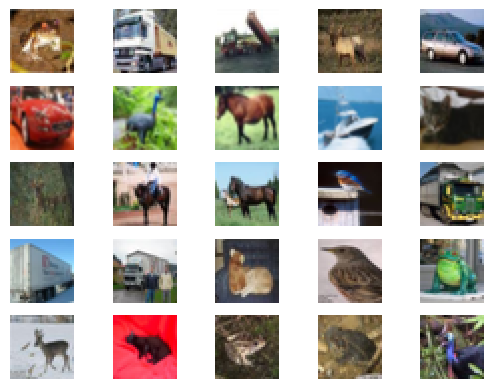

In [4]:
##############################################
#  COMPLETE CODE BELOW WHERE YOU SEE # ...   #
##############################################

def show_imgs(X):
    """ Plot 5x5 grid of images """
    plt.figure(1)
    k = 0
    for i in range(0,5):
        for j in range(0,5):
            plt.subplot2grid((5,5),(i,j))
            plt.imshow(X[k], cmap='gray')
            k = k+1
            plt.axis('off')
    plt.show()
    
# Load data & split data between train and test sets
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# NOTE: Returns numpy arrays, not tensors like pytorch

show_imgs(X_train)

In [5]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (50000, 32, 32, 3)
X_test.shape:  (10000, 32, 32, 3)
y_test.shape:  (10000, 1)


In [6]:
print("X_train.shape: ", X_train.shape)

X_train.shape:  (50000, 32, 32, 3)


In [7]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
D_flattened = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]

# Flatten Image Dimensions
X_train =  X_train.reshape(N_train, D_flattened)  
X_test =   X_test.reshape(N_test, D_flattened)   

# Change Datatype to float
X_train =  X_train.astype('float32')   
X_test =   X_test.astype('float32')     

# Normalize the range to be between 0.0 and 1.0
X_train /= np.max(X_train)                  
X_test /= np.max(X_test)       

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


#### Switch to one-hot encoding for y-vector

The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [8]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [9]:
# convert single class number to one-hot encoding
Y_train = keras.utils.to_categorical(y_train)            
Y_test = keras.utils.to_categorical(y_test)     
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


# One-layer network and weight visualisation
## Define the network

Adding L2 regulization (adding cost based on weight vector length) with $\lambda = 0.05$

$$ C = C_{MSE} + \lambda C_{Reg}(W) $$

![L2 Regularization](img/l2.png)

In [10]:
E = 5                 # number of epochs
B = 128               # batch size

D = X_train.shape[1]  # dimension of input sample - 784 for MNIST
M = Y_train.shape[1]  # dimension of output vector


# Define the model as a Sequential type
model = tf.keras.models.Sequential()
model.add(keras.Input(shape=(D,)))
model.add(keras.layers.Dense(units=M, activation='softmax',kernel_regularizer=keras.regularizers.L2(0.05))) # fully connected (linear) layer 

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │        30,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and train the network

In [11]:
# ... compile the model with a crossentropy loss, rmsprop optimizer 
#      and defining metrics to be stored as history of the training

# use cheat sheet!
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) # track accuracy on validation batches throughout training
                                    # (at end of each epoch)

# ... call the training with the fit() function giving the tensors as 
#     inputs, defining batch size, number of epochs and validation data

log = model.fit(
    X_train,
    Y_train,
    batch_size=B,
    epochs=E,
    verbose=1,
    validation_data=(X_test, Y_test) # no separate test data
)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2671 - loss: 2.6431 - val_accuracy: 0.3208 - val_loss: 2.0437
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3235 - loss: 2.0218 - val_accuracy: 0.3049 - val_loss: 2.0244
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3287 - loss: 1.9924 - val_accuracy: 0.3127 - val_loss: 2.0112
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3252 - loss: 1.9975 - val_accuracy: 0.3317 - val_loss: 1.9840
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3309 - loss: 1.9860 - val_accuracy: 0.3482 - val_loss: 1.9566


## Evaluate the network

### Loss evolution during training

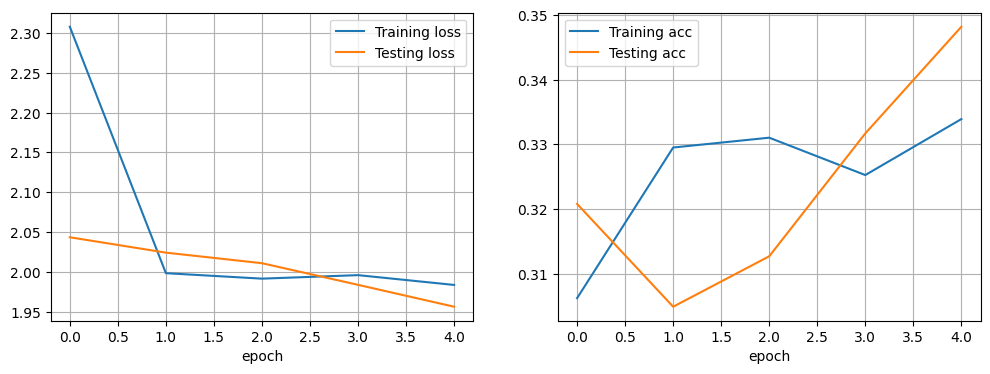

In [12]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.grid()

ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.set_xlabel('epoch')
ax2.legend()
ax2.grid()

### Model evaluation on test set

In [13]:
loss_test, metric_test = model.evaluate(X_test, Y_test) # evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.3517 - loss: 1.9570
Test loss: 1.9552565813064575
Test accuracy: 0.3481999933719635


#### Confusion matrix

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


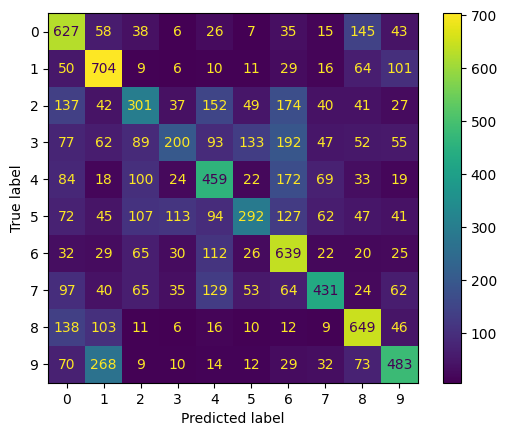

In [24]:
pred = model.predict(X_test, batch_size=B) # get the output posterior probabilities
y_pred = np.argmax(pred, axis=1) # collapse one-hot back to class nr by choosing max predicted probability
cm = confusion_matrix(y_test, y_pred) # ... get the confusion matrix with scikit learn confusion_matrix()

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

In [16]:
def normalizeChannel(im):
    """ min-max norm applied to given RGB channel of weight-imge"""
    min = np.min(im)
    max = np.max(im)
    return ((im - min)/(max - min))

(3072, 10)
(10,)


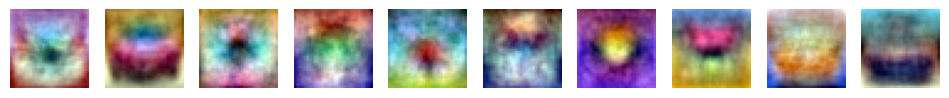

In [17]:
weights = model.get_weights()

for w in weights:
    print(w.shape)

w1 = weights[0]
f = plt.figure(figsize=(12,12))
for i in range(10):
    ax = f.add_subplot(1, 10, 1+i)
    im = w1[:,i]                  # get the weights landing to neuron i
    im = im.reshape(32,32,3)      # reshape the vector of weights into input image dims
    
    # now put back the pixel values to 0-1 doing a *min-max norm* 
    im[:,:,0] = normalizeChannel(im[:,:,0])
    im[:,:,1] = normalizeChannel(im[:,:,1])
    im[:,:,2] = normalizeChannel(im[:,:,2])

    ax.axis('off')
    ax.imshow(im)

# Two-Layer Network

Adding one hidden layer with the following params:
- units:            128
- activation:       relu
- regularization:   none

Train for 30 epochs with batch-size 128

In [40]:
E = 300                # number of epochs
B = 128               # batch size

D = X_train.shape[1]  # dimension of input sample - 784 for MNIST
M = Y_train.shape[1]  # dimension of output vector


# Define the model as a Sequential type
model = tf.keras.models.Sequential()
model.add(keras.Input(shape=(D,)))
model.add(keras.layers.Dense(units=1024, activation='relu'))   # added hidden layer
model.add(keras.layers.Dense(units=1024, activation='relu'))   # added hidden layer
model.add(keras.layers.Dense(units=512, activation='relu'))   # added hidden layer
model.add(keras.layers.Dense(units=256, activation='relu'))   # added hidden layer
model.add(keras.layers.Dense(units=128, activation='relu'))   # added hidden layer
model.add(keras.layers.Dense(units=64, activation='relu'))   # added hidden layer
model.add(keras.layers.Dense(units=M,   activation='softmax')) 

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,894,282 (18.67 MB)

 Trainable params: 4,894,282 (18.67 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train

In [41]:
# ... compile the model with a crossentropy loss, rmsprop optimizer 
#      and defining metrics to be stored as history of the training

# use cheat sheet!
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) # track accuracy on validation batches throughout training
                                    # (at end of each epoch)

# ... call the training with the fit() function giving the tensors as 
#     inputs, defining batch size, number of epochs and validation data

log = model.fit(
    X_train,
    Y_train,
    batch_size=B,
    epochs=E,
    verbose=1,
    validation_data=(X_test, Y_test) # no separate test data
)

Epoch 1/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.2017 - loss: 2.1484 - val_accuracy: 0.3370 - val_loss: 1.8313
Epoch 2/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.3498 - loss: 1.7851 - val_accuracy: 0.4017 - val_loss: 1.6829
Epoch 3/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.3928 - loss: 1.6764 - val_accuracy: 0.3975 - val_loss: 1.6519
Epoch 4/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.4188 - loss: 1.6090 - val_accuracy: 0.4424 - val_loss: 1.5537
Epoch 5/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.4525 - loss: 1.5299 - val_accuracy: 0.4455 - val_loss: 1.5327
Epoch 6/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.4618 - loss: 1.4971 - val_accuracy: 0.4682 - val_loss: 1.5085
Epoch 7/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.4847 - loss: 1.4395 - val_accuracy: 0.4697 - val_loss: 1.4973
Epoch 8/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.4918 - loss: 1

## Evaluate the Network

### Training History

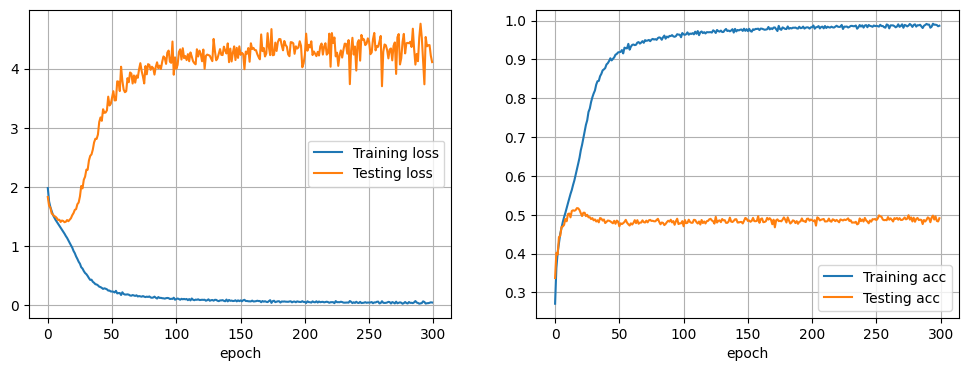

In [42]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.grid()

ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.set_xlabel('epoch')
ax2.legend()
ax2.grid()

- Already running into overfitting with 30 epochs --> Adding more won't help generalization performance

## Evaluation of test set

In [43]:
loss_test, metric_test = model.evaluate(X_test, Y_test) # evaluate model performance on test set
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4897 - loss: 4.1318
Test loss: 4.108078956604004
Test accuracy: 0.4909000098705292


### Confusion Matrix

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


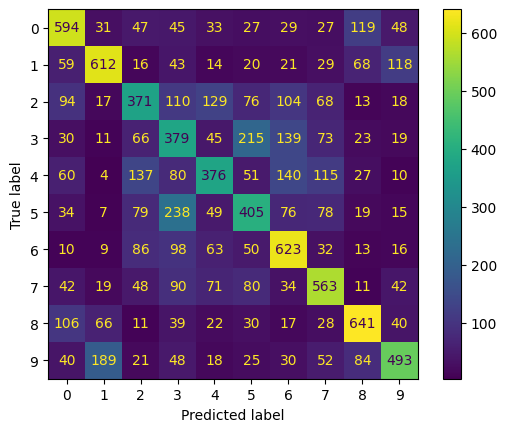

In [38]:
pred = model.predict(X_test, batch_size=B) # get the output posterior probabilities
y_pred = np.argmax(pred, axis=1) # collapse one-hot back to class nr by choosing max predicted probability
cm = confusion_matrix(y_test, y_pred) # ... get the confusion matrix with scikit learn confusion_matrix()

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Different NN parameter test results:

- 48% accuracy with single hidden layer (128 units, relu)
- 51% accuracy with two identical hidden layers (128 units, relu)
- 49% accuracy with 5 identical, smaller hidden layers (64 units, relu)
- 50% accuracy with **CHONKY** 5-layer network with decreasing number of units with increasing layer depth (1028, 512, 256, 128, 64)

Also tried to get into double descent by training for 300 epochs on the largest network. Didn't happen. Guessing fully connected networks just too ill-suited for image classification task.